In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

import time
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *

import sys
sys.path.append("/home/student/notebooks/Student/Face-Mask-Recognition/")

from FaceMaskDataset import FaceMaskDataset
from FaceMaskModel import MobileNetV3

from Conv3dModel import CNN

sns.set()

ROOT_DIR='/StudentData/hw2_data'


## Exploratory Data Analysis

In [2]:
from glob import glob

train_imgs = glob(f'{ROOT_DIR}/train/*.jpg')
test_imgs = glob(f'{ROOT_DIR}/test/*.jpg')

print(f"Train-set Size: {len(train_imgs)}")
print(f"Test-set Size: {len(test_imgs)}")

Train-set Size: 18259
Test-set Size: 6086


In [3]:
from PIL import Image
from os.path import basename

def plot_25_imgs(imgs_list):
    plt.figure(figsize=(10,10))

    for i, image in enumerate(imgs_list):
        if i == 25:
            break
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(Image.open(image))
        plt.xlabel(basename(image))
    plt.show()

Train Images Sample:


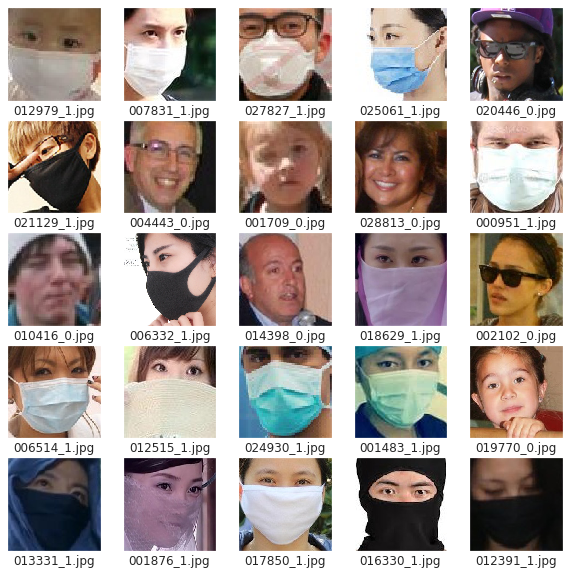

In [4]:
print("Train Images Sample:")
plot_25_imgs(train_imgs)

Test Images Sample:


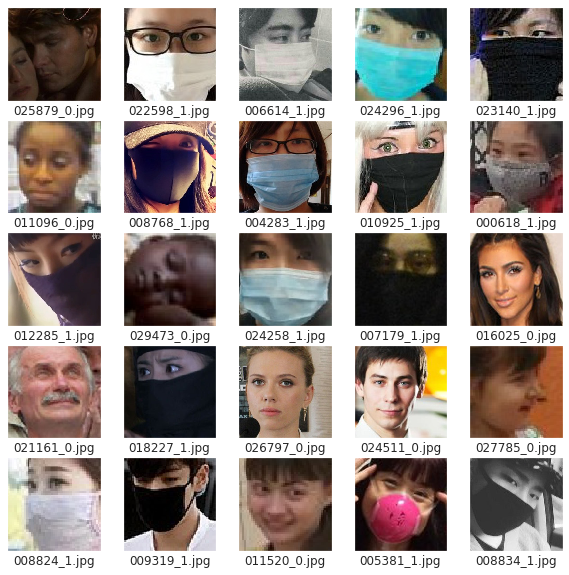

In [5]:
print("Test Images Sample:")
plot_25_imgs(test_imgs)

In [10]:


train_labels = pd.Series([int(image_path.split('.jpg')[0][-1]) for image_path in train_imgs])
test_labels = pd.Series([int(image_path.split('.jpg')[0][-1]) for image_path in test_imgs])

Train Mask/No-Mask Plot:


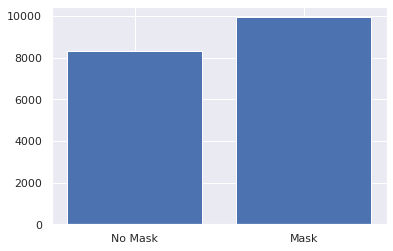

In [23]:
plt.bar((0,1) , (int((1 - train_labels.mean()) * train_labels.shape[0]), int(train_labels.mean() * train_labels.shape[0])))
plt.xticks((0,1), ('No Mask', 'Mask'))
print("Train Mask/No-Mask Plot:")
plt.show()

Test Mask/No-Mask Plot:


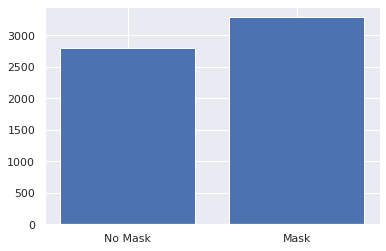

In [24]:
plt.bar((0,1) , (int((1 - test_labels.mean()) * test_labels.shape[0]), int(test_labels.mean() * test_labels.shape[0])))
plt.xticks((0,1), ('No Mask', 'Mask'))
print("Test Mask/No-Mask Plot:")
plt.show()

In [ ]:
test_labels.plot.bar()

In [10]:
def train_model(model, train_dataloader, eval_dataloaders, datasets_sizes, criterion, optimizer, device='cuda:0', num_epochs=20, print_epoch=1, scheduler=None, data_types=['train', 'test'], save_model=False):
    start_time = time.time()
    best_f1 = 0.0
    best_model = deepcopy(model.state_dict())

    epoch_losses = {data_type: [] for data_type in data_types}
    epoch_aucs = {data_type: [] for data_type in data_types}
    epoch_f1s = {data_type: [] for data_type in data_types}
    
    for epoch in range(0, num_epochs + 1):
        start_epoch = time.time()
        print("Epoch [{}/{}]".format(str(epoch).zfill(len(str(num_epochs))), num_epochs))
        
        if epoch != 0:
            model.train()

            for _, images, labels in train_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs = model(images)
                    
                    loss = criterion(outputs, labels)
                    
                    loss.backward()
                    optimizer.step()
            if scheduler is not None:
                scheduler.step()
           
        model.eval()
        
        for data_type in data_types:
            epoch_loss = 0.0
            
            y_true = np.empty(0)
            y_pred = np.empty(0)
            y_score = np.empty(0)
        
            for _, images, labels in eval_dataloaders[data_type]:
                y_true = np.append(y_true, labels.numpy())
                
                images = images.to(device)
                labels = labels.to(device)
                                
                with torch.set_grad_enabled(False):
                    outputs = model(images)
            
                    loss = criterion(outputs, labels)
                
                    scores = F.softmax(outputs, 1)[:,1]
                    y_score = np.append(y_score, scores.to('cpu').numpy())
                    
                    _, pred = torch.max(outputs, 1)
                    y_pred = np.append(y_pred, pred.to('cpu').numpy())
                        
                epoch_loss += loss.item() * images.size(0)
                
            epoch_loss = epoch_loss / datasets_sizes[data_type]
            epoch_acc = accuracy_score(y_true, y_pred) * 100
            epoch_p = precision_score(y_true, y_pred, zero_division=0) * 100
            epoch_r = recall_score(y_true, y_pred, zero_division=0) * 100
            epoch_f1 = f1_score(y_true, y_pred, average='binary', zero_division=0) * 100
            epoch_roc_auc = roc_auc_score(y_true, y_score) * 100

            epoch_losses[data_type].append(epoch_loss)
            epoch_aucs[data_type].append(epoch_roc_auc)
            epoch_f1s[data_type].append(epoch_f1)
            
            print('{} Loss: {:.4f} F1: {:2.2f} Precision: {:2.2f} Recall: {:2.2f} Accuracy: {:2.2f} ROC-AUC: {:2.2f}'
                    .format(data_type.ljust(5), epoch_loss, epoch_f1, epoch_p, epoch_r, epoch_acc, epoch_roc_auc))
            
            if data_type == 'test' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model = deepcopy(model.state_dict())
        
        epoch_elapsed = time.time() - start_epoch
        print('Epoch {} took {}m {:.0f}s'
                .format(epoch, int(epoch_elapsed // 60), epoch_elapsed % 60))
        
        print('-' * 90)
        
    time_elapsed = time.time() - start_time
    print('Training complete in {}m {:.0f}s'
            .format(int(time_elapsed // 60), time_elapsed % 60))

    loss_df = pd.DataFrame(epoch_losses)
    auc_df = pd.DataFrame(epoch_aucs)
    f1_df = pd.DataFrame(epoch_f1s)

    melted_loss = pd.melt(loss_df.reset_index(), 'index').rename(columns={'index': 'Epoch', 'variable': 'Phase', 'value':'Loss'})
    melted_auc = pd.melt(auc_df.reset_index(), 'index').rename(columns={'index': 'Epoch', 'variable': 'Phase', 'value':'AUC'})
    melted_f1 = pd.melt(f1_df.reset_index(), 'index').rename(columns={'index': 'Epoch', 'variable': 'Phase', 'value':'F1-Score'})

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,15))

    sns.lineplot(x='Epoch', y='Loss', hue='Phase', data=melted_loss, ax=ax1).set_xticks(range(0,21))
    sns.lineplot(x='Epoch', y='AUC', hue='Phase', data=melted_auc, ax=ax2).set_xticks(range(0,21))
    sns.lineplot(x='Epoch', y='F1-Score', hue='Phase', data=melted_f1, ax=ax3).set_xticks(range(0,21))

    plt.show()

    print('Best test F1: {:2f}'.format(best_f1))
    if save_model:
        torch.save(best_model, 'model_{:2f}.pkl'.format(best_f1))
    model.load_state_dict(best_model)
    return model

In [24]:
phases = ['train', 'eval']
data_types = ['train', 'test']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
train_dataset = FaceMaskDataset(root_dir=f'{ROOT_DIR}/train', have_label=True, phase='train')
eval_datasets = {data_type : FaceMaskDataset(root_dir=f'{ROOT_DIR}/{data_type}', have_label=True,  phase='eval') for data_type in data_types}

datasets_sizes = {data_type : len(eval_datasets[data_type]) for data_type in data_types}

In [13]:
batch_sizes = {
    'train' : 128,
    'eval' : 64
}

shuffles = {
    'train' : True,
    'eval' : False
}

train_dataloader = DataLoader(train_dataset, batch_sizes['train'], shuffles['train'])
eval_dataloaders = {data_type : DataLoader(eval_datasets[data_type], batch_sizes['eval'], shuffles['eval']) for data_type in data_types}

In [14]:
model = MobileNetV3(n_class=2, input_size=224, dropout=0.0, mode='large', width_mult=1.0)
model = model.to(device)
print('Total Number of Parameters: {:.2f}M'.format(sum(param.numel() for param in model.parameters()) / 1e6))

Total Number of Parameters: 4.20M


In [15]:
# learning_rate *= gamma every (step_size) epochs
learning_rate = 1e-3
step_size = 5
gamma = 1e-1

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Epoch [00/20]
train Loss: 0.6931 F1: 70.54 Precision: 54.49 Recall: 100.00 Accuracy: 54.49 ROC-AUC: 50.00
test  Loss: 0.6931 F1: 70.18 Precision: 54.06 Recall: 100.00 Accuracy: 54.06 ROC-AUC: 50.00
Epoch 0 took 1m 46s
------------------------------------------------------------------------------------------
Epoch [01/20]
train Loss: 0.1703 F1: 94.95 Precision: 92.26 Recall: 97.80 Accuracy: 94.33 ROC-AUC: 98.46
test  Loss: 0.1703 F1: 94.78 Precision: 91.99 Recall: 97.75 Accuracy: 94.18 ROC-AUC: 98.49
Epoch 1 took 4m 17s
------------------------------------------------------------------------------------------
Epoch [02/20]
train Loss: 0.1249 F1: 95.86 Precision: 95.78 Recall: 95.95 Accuracy: 95.49 ROC-AUC: 99.01
test  Loss: 0.1281 F1: 95.74 Precision: 95.80 Recall: 95.68 Accuracy: 95.40 ROC-AUC: 98.93
Epoch 2 took 4m 17s
------------------------------------------------------------------------------------------
Epoch [03/20]
train Loss: 0.1026 F1: 96.63 Precision: 94.70 Recall: 98.63 Acc

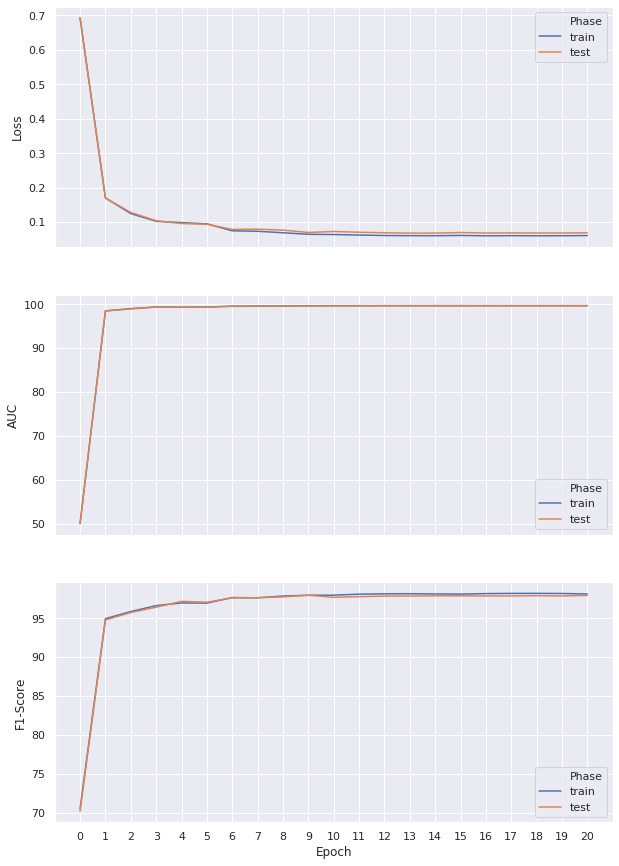

Best test F1: 97.957949


In [16]:
best_model = train_model(model, train_dataloader, eval_dataloaders, datasets_sizes, criterion, optimizer, device=device, scheduler=scheduler)

In [17]:
torch.save(best_model.state_dict(), "mask_model.pt")

## Second Model:

In [18]:
model = CNN(num_class=2)
model = model.to(device)
print('Total Number of Parameters: {:.2f}M'.format(sum(param.numel() for param in model.parameters()) / 1e6))

Total Number of Parameters: 0.09M


In [19]:
# Hyper Parameters
num_epochs = 2000
batch_size = 64
lr = 0.001

# Loss and Optimizer
# Softmax is internally computed.
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

Epoch [00/20]
train Loss: 0.6940 F1: 0.00 Precision: 0.00 Recall: 0.00 Accuracy: 45.52 ROC-AUC: 41.24
test  Loss: 0.6939 F1: 0.00 Precision: 0.00 Recall: 0.00 Accuracy: 45.94 ROC-AUC: 40.85
Epoch 0 took 1m 32s
------------------------------------------------------------------------------------------
Epoch [01/20]
train Loss: 0.3977 F1: 88.05 Precision: 80.22 Recall: 97.58 Accuracy: 85.57 ROC-AUC: 96.00
test  Loss: 0.3786 F1: 88.71 Precision: 81.18 Recall: 97.78 Accuracy: 86.54 ROC-AUC: 96.50
Epoch 1 took 2m 36s
------------------------------------------------------------------------------------------
Epoch [02/20]
train Loss: 0.2095 F1: 93.30 Precision: 92.67 Recall: 93.93 Accuracy: 92.64 ROC-AUC: 97.18
test  Loss: 0.2028 F1: 93.72 Precision: 93.36 Recall: 94.07 Accuracy: 93.18 ROC-AUC: 97.40
Epoch 2 took 2m 36s
------------------------------------------------------------------------------------------
Epoch [03/20]
train Loss: 0.2157 F1: 93.24 Precision: 90.04 Recall: 96.67 Accuracy: 9

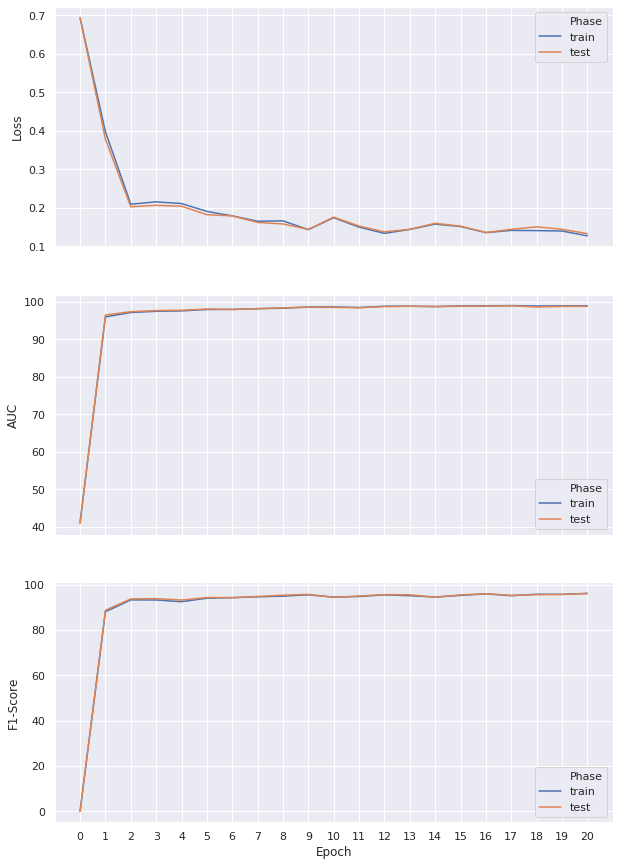

Best test F1: 96.100030


In [20]:
best_model = train_model(model, train_dataloader, eval_dataloaders, datasets_sizes, criterion, optimizer, device=device)

In [21]:
torch.save(best_model.state_dict(), "2nd_mask_model.pt")